# Generating CCI images

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

# Dataset 1 - generating ligand and receptor pathway distribution

load input data

In [4]:
input_data = pd.read_csv(f"/data/GraphComm_Output/Drosophila/CCI.csv",index_col=0)
input_data.columns =["Ligand","Receptor","Prob"]

load pathway data from KEGG

In [5]:
pathways = pd.read_csv("/data/LR_database/kegg_pathways.csv",index_col=0)
pathways.index = pathways["genesymbol"].tolist()
pathways = pathways.drop_duplicates("genesymbol")

find interactions where ligand and receptor have an assigned pathway & subset for only top 1000 interactions

In [6]:
input_data = input_data[(input_data["Ligand"].isin(pathways["genesymbol"].tolist())) & (input_data["Receptor"].isin(pathways["genesymbol"].tolist()))]
involved_ligands = list(set(input_data["Ligand"].tolist()) & set(pathways["genesymbol"].tolist()))
involved_receptors = list(set(input_data["Receptor"].tolist()) & set(pathways["genesymbol"].tolist()))
input_data["Ligand Pathway"] = pathways.loc[input_data["Ligand"].tolist()]["pathway"].tolist()
input_data["Receptor Pathway"] = pathways.loc[input_data["Receptor"].tolist()]["pathway"].tolist()
input_data.index = range(0,input_data.shape[0])
input_data = input_data.head(1000)

find genes which participate in Hippo pathway

In [7]:
hippo_genes = pathways[pathways["pathway"].str.contains("Hippo")]["genesymbol"].tolist()

 find CCC interactions that have either a ligand or receptor participating in the hippo pathway (to maintain relevance in Drosophila as well, i have filtered out any diabetes/disease/cancer pathways)

In [8]:
signaling_pathway = input_data[(input_data["Ligand"].isin(hippo_genes)) | (input_data["Receptor"].isin(hippo_genes))]
signaling_pathway = signaling_pathway[(~signaling_pathway["Ligand Pathway"].str.contains("disease")) & (~signaling_pathway["Receptor Pathway"].str.contains("disease"))]
signaling_pathway = signaling_pathway[(~signaling_pathway["Ligand Pathway"].str.contains("diabetes")) & (~signaling_pathway["Receptor Pathway"].str.contains("diabetes"))]

identify the other pathways interacting with Hippo

In [9]:
possible_pathways = signaling_pathway["Ligand Pathway"].unique().tolist()
possible_pathways = list(set(possible_pathways + signaling_pathway["Receptor Pathway"].unique().tolist()))

## Investigating coverage of hippo genes (Figure 2B)

from the original matrices, identify the genes that are a) interacting proteins and b) involved in the hippo pathway

In [10]:
#matrix = pd.read_csv("../data/GSE95025/GSM2494785_dge_mel_rep3.txt",sep="\t")
matrix_list = []
common_genes = []
for i,j in zip(range(3,8),range(5,10)):
    matrix_list.append(pd.read_csv(f"/data/raw_data/Drosophila/GSM249478{j}_dge_mel_rep{i}.txt",sep="\t",index_col=0))
    if not common_genes:
        common_genes = pd.read_csv(f"/data/raw_data/Drosophila/GSM249478{j}_dge_mel_rep{i}.txt",sep="\t",index_col=0).index.tolist()
    else:
        common_genes = list(set(common_genes) & set(pd.read_csv(f"/data/raw_data/Drosophila/GSM249478{j}_dge_mel_rep{i}.txt",sep="\t",index_col=0).index.tolist()))
        #matrix_list = [i.loc[common_genes] for i in matrix_list]
matrix = pd.concat(matrix_list)
matrix = matrix.loc[common_genes]
matrix = matrix[~matrix.index.duplicated(keep='first')]
matrix.index = [str(i).upper() for i in matrix.index.tolist()]

moving the hippo signalling pathway to the end, so the coverage appears at the front on the plot

In [11]:
possible_pathway = possible_pathways.remove("Hippo signaling pathway")
possible_pathways += ["Hippo signaling pathway"]

for the top 0-1000 interactions, increasing by intervals of 100, identify the coverage of each of the "possible pathways" identified before

In [12]:
Omnipath_db = pd.read_csv("/data/LR_database/Omnipath_database.csv",index_col=0)

In [13]:
available_LRs = set(Omnipath_db["from"].tolist() + Omnipath_db["to"].tolist())

In [14]:
available_LRs = list(set(available_LRs)&set(hippo_genes))

In [15]:
available_hippo_genes = list(set(matrix.index.tolist()) & set(available_LRs))

In [16]:
pathway_coverage_list = []
for i in possible_pathways:
    hippo_genes = pathways[pathways["pathway"].str.contains(i)]["genesymbol"].tolist()
    Omnipath_db = pd.read_csv("/data/LR_database/Omnipath_database.csv",index_col=0)
    available_LRs = set(Omnipath_db["from"].tolist() + Omnipath_db["to"].tolist())
    available_LRs = list(set(available_LRs)&set(hippo_genes))
    available_hippo_genes = list(set(matrix.index.tolist()) & set(available_LRs))
    sizes_list = []
    for i in range(0,1000,100):
        temp = input_data.head(i)
        found_genes = temp["Ligand"].tolist() + temp["Receptor"].tolist()
        found_hippo_genes = list(set(found_genes) & set(hippo_genes))
        sizes_list.append(len(found_hippo_genes) / len(available_hippo_genes))
    pathway_coverage_list.append(sizes_list)

In [17]:
# sizes_list = []
# for i in range(0,1000,100):
#     temp = input_data.head(i)
#     found_genes = temp["Ligand"].tolist() + temp["Receptor"].tolist()
#     found_hippo_genes = list(set(found_genes) & set(hippo_genes))
#     sizes_list.append(len(found_hippo_genes) / len(available_hippo_genes))

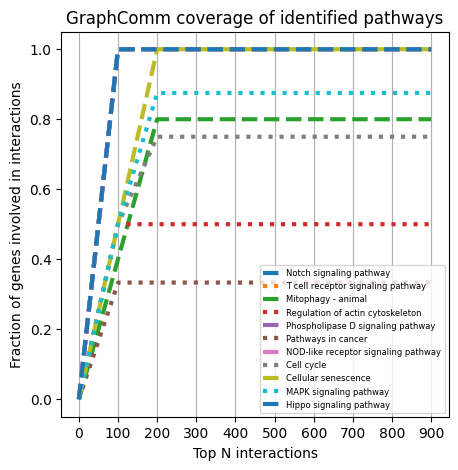

In [18]:
%matplotlib inline
plt.figure(figsize=(5,5))
line_styles = ['--',":"]*10
for i in range(len(pathway_coverage_list)):
    plt.plot(range(0,1000,100),pathway_coverage_list[i],markersize=5,linestyle=line_styles[i],label=possible_pathways[i],linewidth=3)
plt.xticks(range(0,1000,100))
plt.grid(axis = 'x')
plt.title("GraphComm coverage of identified pathways")
plt.xlabel("Top N interactions")
plt.ylabel("Fraction of genes involved in interactions")
plt.legend(loc='lower right',fontsize=6)


## Comparing coverage of Original set vs. Randomization coverage of Hippo pathway genes (Fig 2C)

In [19]:
df_list = []
for i in range(10,100):
    df_list.append(pd.read_csv(f"/data/random_data/Drosophila/Drosophila_{i+1}_random.csv",index_col=0).head(1000))

In [20]:
hippo_genes = pathways[(pathways['pathway'].str.contains("Hippo"))]["genesymbol"].tolist()

In [21]:
available_hippo_genes = list(set(matrix.index.tolist()) & set(hippo_genes))

In [22]:
original_sizes_list = []
for i in range(0,1000,100):
    temp = input_data.head(i)
    found_genes = temp["Ligand"].tolist() + temp["Receptor"].tolist()
    found_hippo_genes = list(set(found_genes) & set(hippo_genes))
    original_sizes_list.append(len(found_hippo_genes) / len(available_hippo_genes))

In [23]:
random_sizes_list = []
for j in df_list:
    sizes_list = []
    for i in range(0,1000,100):
        temp = j.head(i)
        found_genes = temp["Src"].tolist() + temp["Dst"].tolist()
        found_hippo_genes = list(set(found_genes) & set(hippo_genes))
        sizes_list.append(len(found_hippo_genes) / len(available_hippo_genes))
    random_sizes_list.append(sizes_list)

In [24]:
random_sizes_list = np.array(random_sizes_list)

capture average coverage for top N interactions across 100 randomized interactions

In [25]:
random_averages = np.mean(random_sizes_list,axis=0)

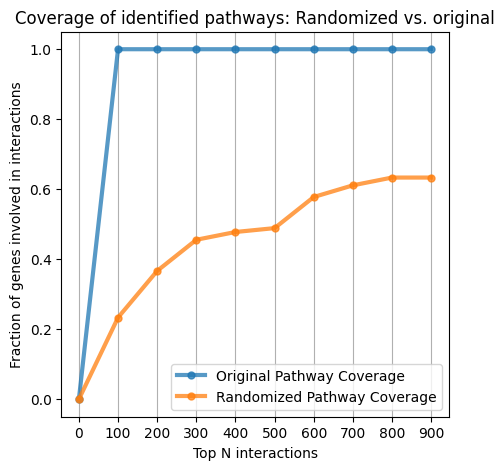

In [27]:
plt.figure(figsize=(5,5))
line_styles = ["-.",'--',":"]*4
plt.plot(range(0,1000,100),original_sizes_list,markersize=5,label="Original Pathway Coverage",marker="o",linewidth=3,alpha=0.75)
plt.plot(range(0,1000,100),random_averages,markersize=5,label="Randomized Pathway Coverage",marker="o",linewidth=3,alpha=0.75)

plt.xticks(range(0,1000,100))
plt.grid(axis = 'x')
plt.title("Coverage of identified pathways: Randomized vs. original")
plt.xlabel("Top N interactions")
plt.ylabel("Fraction of genes involved in interactions")
plt.legend()

# Dataset 2:scRNA dataset with drug treatment - change comparison datasets to generate pre/post or biological replicate overlap (Figure 3B,C)

### load datasets

In [29]:
day0=pd.read_csv("/data/GraphComm_Output/Pre_Post/Day0/CCI.csv",index_col=0)
day7_rep1=pd.read_csv("/data/GraphComm_Output/Pre_Post/Day7_1//CCI.csv",index_col=0)
day7_rep2=pd.read_csv("/data/GraphComm_Output/Pre_Post/Day7_2/CCI.csv",index_col=0)

In [30]:
Omnipath_database = pd.read_csv("/data/LR_database/intercell_Omnipath.csv",index_col=0)

In [31]:
Omnipath_database.columns = ["from","to","references"]

### only retain, within each dataset, **validated intercell interactions from Omnipath**

In [32]:
day0=pd.merge(day0,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()
day7_rep1=pd.merge(day7_rep1,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()
day7_rep2=pd.merge(day7_rep2,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()

### find the number of common interactions within the top 100 between biological replicates (and save that value for the randomization experiment)

In [33]:
common = pd.merge(day7_rep2.head(100),day7_rep1.head(100))

In [35]:
original_accuracy = common.shape[0]/100

### use a stacked bar plot to visualize the commonalities

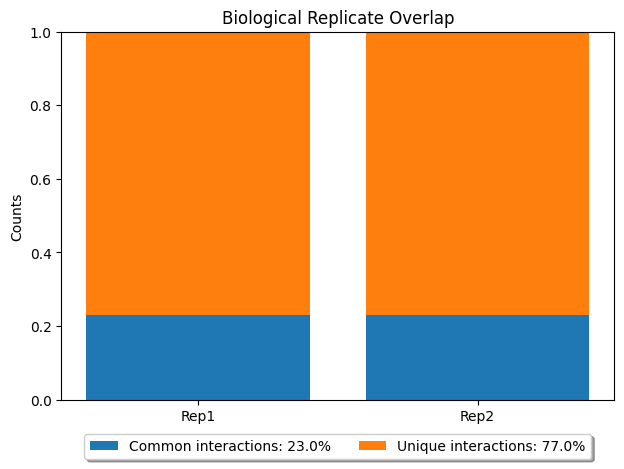

In [36]:
%matplotlib inline
labels = ["Rep1","Rep2"]
men_means = [round(common.shape[0]/100,3),round(common.shape[0]/100,3)]
women_means = [1- round(common.shape[0]/100,3),1- round(common.shape[0]/100,3)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, label=f"Common interactions: {round(common.shape[0]/100*100,3)}%")
ax.bar(labels, women_means, bottom=men_means,
       label=f"Unique interactions: {round(100-round(common.shape[0]/100*100,3),2)}%")

ax.set_ylabel("Counts")
ax.set_title("Biological Replicate Overlap")
ax.set_ylim((0,1))
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.18),
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()
#plt.savefig("/results/bio_rep.png")
plt.show()


### find the number of common interactions within the top 100 between pre and post treatment datasets (and save that value for the randomization experiment)

In [41]:
common = pd.merge(day0.head(100),day7_rep1.head(100))

### use a stacked bar plot to visualize the commonalities

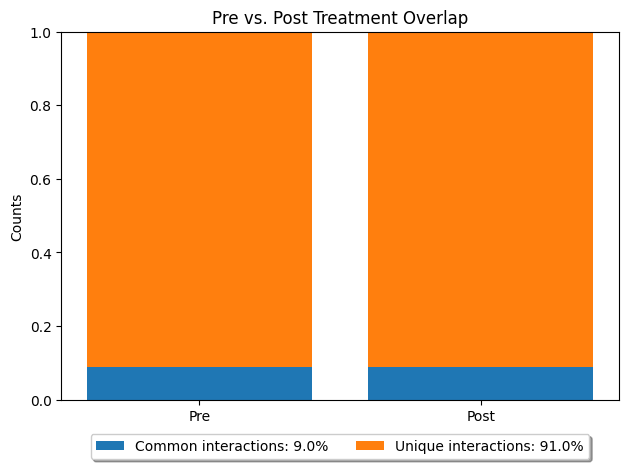

In [42]:
%matplotlib inline
labels = ["Pre","Post"]
men_means = [round(common.shape[0]/100,3),round(common.shape[0]/100,3)]
women_means = [1- round(common.shape[0]/100,3),1- round(common.shape[0]/100,3)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, label=f"Common interactions: {round(common.shape[0]/100*100,3)}%")
ax.bar(labels, women_means, bottom=men_means,
       label=f"Unique interactions: {round(100-round(common.shape[0]/100*100,3),2)}%")

ax.set_ylabel("Counts")
ax.set_title("Pre vs. Post Treatment Overlap")
ax.set_ylim((0,1))
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.18),
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()
#plt.savefig("/results/bio_rep.png")
plt.show()


# Compare Biological Replicate Overlap between Original Set and 100 Randomized Interactions

### load the datasets

In [57]:
rep1_list = []
rep2_list = []
for i in range(100):
    rep1_list.append(pd.read_csv(f"/data/random_data/Pre_Post/Rep1_{i+1}_random.csv",index_col=0)[["Src","Dst"]])
    rep2_list.append(pd.read_csv(f"/data/random_data/Pre_Post/Rep2_{i+1}_random.csv",index_col=0)[["Src","Dst"]])

In [58]:
Omnipath_database = pd.read_csv("/data/LR_database/intercell_Omnipath.csv",index_col=0)[["source","target"]].drop_duplicates()
Omnipath_database.columns = ["from","to"]

#### within each randomized Rep1 and Rep2, subset for validated intercell interactions

In [59]:
rep1_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in rep1_list]

In [60]:
rep2_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in rep2_list]

In [61]:
rep1_list = [i[["Src","Dst"]] for i in rep1_list]
rep2_list = [i[["Src","Dst"]] for i in rep2_list]

In [62]:
merged_list = [pd.merge(i.head(100),j.head(100)) for i,j in zip(rep1_list,rep2_list)]

### find the fraction of overlap between each set of replicates

In [63]:
accuracy_list = [i.shape[0]/100 for i in merged_list]

In [64]:
accuracy_list.sort()

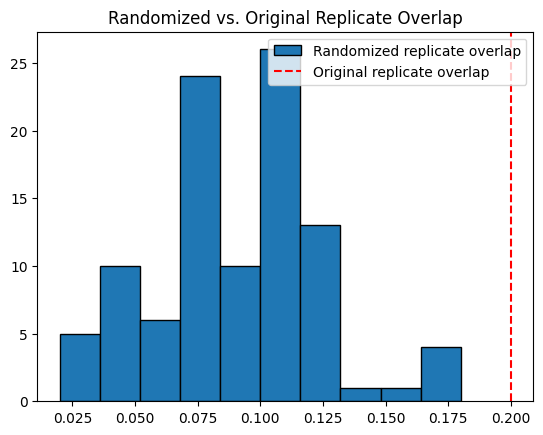

In [65]:
plt.hist(accuracy_list,edgecolor='black',rwidth=1,label="Randomized replicate overlap")
plt.axvline(original_accuracy,linestyle="--",color="red",label="Original replicate overlap")
plt.title("Randomized vs. Original Replicate Overlap")
plt.legend()
#plt.xlim((min(accuracy_list),max(accuracy_list)))

# Dataset 3 - generating spatial maps (Fig 4B,C,D)

### visualize the total spatial map of tissue

In [67]:
input_data = pd.read_csv("/data/GraphComm_Output/Cardiac_cells/CCI.csv",index_col=0)
input_data.index = range(0,input_data.shape[0])

In [68]:
adata = sc.read_h5ad("/data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")

In [69]:
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

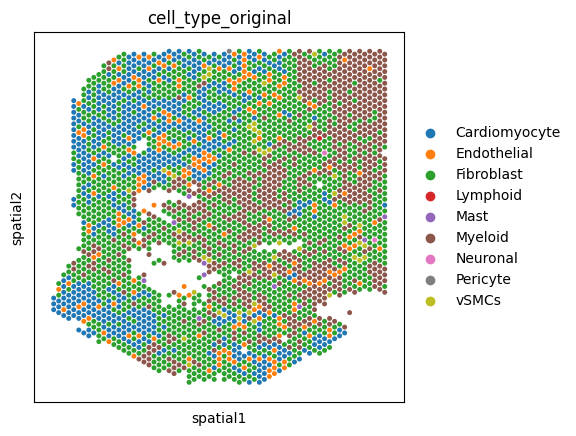

In [70]:
sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original")

### subset for **only validated intercell interactions**, and remove any self loops

In [71]:
intercell_network = pd.read_csv("/data/LR_database/intercell_Omnipath.csv")
intercell_network = intercell_network[~intercell_network["references"].isna()]
#intercell_network = intercell_network[intercell_network["references"].str.contains("SignaLink")]

In [72]:
input_data = pd.merge(input_data,intercell_network,left_on=["Src","Dst"],right_on=["source","target"])

In [73]:
input_data = input_data[input_data["Src Cell"] != input_data["Dst Cell"]]

In [74]:
input_data.index = range(input_data.shape[0])

### visualize top ranked or low ranked interactions by choosing index (change to visualize top ranked/low ranked interactions)

In [75]:
rank = 0

In [76]:
unique_cells = input_data.loc[rank][["Src Cell","Dst Cell"]].tolist()

In [77]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(unique_cells)].index.tolist()

In [78]:
unique_cells = list(set(unique_cells))

In [79]:
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [80]:
adata = adata[unique_cells]

In [81]:
adata.obs["barcode"] = adata.obs.index.tolist()

/tmp/ipykernel_53/2584969232.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [82]:
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

In [83]:
original_input = input_data.copy()

In [84]:
temp = input_data.drop_duplicates(["Src Cell","Dst Cell"],)

In [85]:
new_temp = input_data[(input_data["Src Cell"] == "Mast") & (input_data["Dst Cell"] == "Neuronal")]

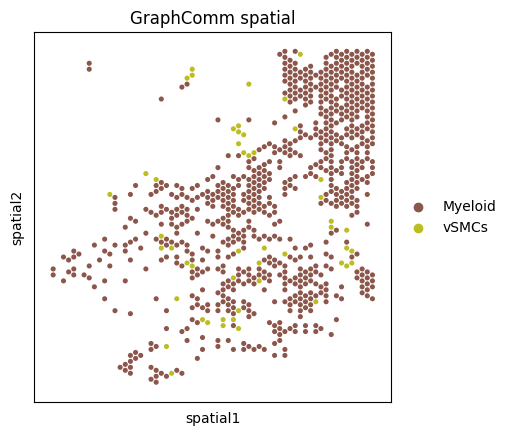

In [86]:
%matplotlib inline
sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",color_map="viridis",title="GraphComm spatial")

In [89]:
input_data.tail(10)

,Src,Dst,Prob,Src Cell,Dst Cell,Unnamed: 0,source,target,references
1437,L1CAM,EZR,1.412394,Neuronal,Cardiomyocyte,8965,L1CAM,EZR,BioGRID:12070130;BioGRID:22846990;CA1:12070130...
1438,L1CAM,ITGAV,1.412394,Neuronal,Cardiomyocyte,72812,L1CAM,ITGAV,CellTalkDB:10871287;HPRD:10871287;LRdb:1087128...
1439,PTPN11,JAK1,1.412162,Pericyte,Neuronal,6574,PTPN11,JAK1,HPRD:11036942;HPRD:12403768;HPRD:8995399;Innat...
1440,ANGPTL4,SDC2,1.412159,Neuronal,Pericyte,74160,ANGPTL4,SDC2,CellChatDB:29017031;Cellinker:29017031
1441,DHH,CDON,1.411982,Fibroblast,Pericyte,71765,DHH,CDON,Baccin2019:18698484;CellTalkDB:20519495;Cellin...
1442,TGFB2,TGFBR1,1.411917,Cardiomyocyte,Neuronal,5507,TGFB2,TGFBR1,Baccin2019:11157750;Baccin2019:12809600;CellTa...
1443,LAMB3,ITGA3,1.411917,Cardiomyocyte,Neuronal,72547,LAMB3,ITGA3,CellTalkDB:32196115
1444,DUSP18,ITGB8,1.411915,Fibroblast,Neuronal,76645,DUSP18,ITGB8,HPMR:7542940
1445,RELN,ITGB1,1.410831,Neuronal,Pericyte,9407,RELN,ITGB1,CA1:10725376;CA1:10939329;CellTalkDB:10939329;...
1446,L1CAM,NRP1,1.410827,Neuronal,Pericyte,76648,L1CAM,NRP1,BioGRID:16377081;HPMR:10520994;HPMR:15121181
